# Airbnb Pricing Algorithm

The scope of this project is to create a deep learning algorithm to predict the price of an Airbnb listing.

This file works with the tabular data provided by the source.

---

> Anna Makropoulou(P2822123)
> 
> Anastasios Safras(P2822130)
> 
> Anastasios Moraitis(P2822124)
> 
> Ioannis Dekoulakos(P2822110)
> 
> Athens University of Economics and Business <br />
> Machine Learning and Content Analytics - PT- PT <br />
 

Nowadays, many Airbnb hosts underestimate their properties and do not know how to maximize their profits. Airbnb is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities. Based in San Francisco, California, the platform is accessible via website and mobile app. Airbnb does not own any of the listed properties; instead, it profits by receiving commission from each booking. The company was founded in 2008 by Brian Chesky, Nathan Blecharczyk, and Joe Gebbia. Airbnb is a shortened version of its original name, AirBedandBreakfast.com. 

The project aims to build an easy-to-use platform leveraging our custom machine learning models built with data from the Greek Airbnb market. The purpose of this service is to offer the end-user a range of suggested pricing segments based on the criteria set as input. Such criteria are the name, description, location, the number of bedrooms, photos of the rental and other features. Consequently, any user expressing an interest to upload a listing on Airbnb can be assisted with a pricing model that will consider more criteria than the basic Airbnb’s pricing model or other models in the market in order to improve or verify their initial assumptions regarding the rental’s price

### Importing the libraries and data

In [1]:
import sys
!pip install chromedriver_autoinstaller
!pip install selenium
!pip install haversine
!pip install pandas
!pip install sklearn
!pip install bs4
!pip install requests
!pip install matplotlib
!pip install seaborn
!{sys.executable} -m pip install livelossplot
!pip install keras
!pip install tensorflow
!pip install xgboost
!pip install IPython
!pip install pydot
!pip install graphviz

In [91]:
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import os
from bs4 import BeautifulSoup
import shutil
from utils import files, delete_file, Constants, extract_values, copy_stream_to_file, try_create_dir, download_data
import requests
import utils as utils
from utils import isBlank, normalize_license_data, fix_price_col, clean_listing_columns, transform_and_import_data
from numpy import NaN
import gzip

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


import seaborn as sns

from datetime import datetime
import time
import matplotlib.pyplot as plt


from PIL import Image, UnidentifiedImageError
from io import BytesIO
from time import sleep

from pylab import *

from pandas.api.types import is_numeric_dtype
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling1D, Conv1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, Adagrad, Ftrl, RMSprop, SGD
from keras.metrics import RootMeanSquaredError
from keras import backend as K
import tensorflow
from keras import regularizers
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# check xgboost version
import xgboost
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from livelossplot import PlotLossesKeras


In [3]:
constants = Constants()

In [4]:
# instance vars
BASE_DIR = constants.DATA_PATH

def acquire_data():
    print("Data will be written into: " + BASE_DIR)

    dict_of_cities = pd.DataFrame(columns=["list_of_cities"]+files)
    dict_of_cities["list_of_cities"] = constants.CITIES
    dict_of_cities.index = dict_of_cities["list_of_cities"].apply(lambda x: x.split(',')[0].lower())

    page = requests.api.get(constants.INSIDE_AIRBNB_DATA_URL)
    soup = BeautifulSoup(page.content, "html.parser")
        
    dict_of_cities.apply(lambda x: extract_values(x, soup), axis=1)

    if os.path.exists(BASE_DIR) == False:
        os.makedirs(BASE_DIR)
    elif __debug__:
        # only for debug
        shutil.rmtree(BASE_DIR, ignore_errors=True)
        os.makedirs(BASE_DIR)

    dict_of_cities.apply(download_data, axis=1)
    dict_of_cities.index.names = ['city_id']
    dict_of_cities.to_csv(os.path.join(BASE_DIR, "description.csv"))

acquire_data()

Data will be written into: /maching_learning_data


Read file

In [5]:
listings = transform_and_import_data(constants.DATA_PATH)

- Drop some columns 

In [6]:
listings.set_index("id", inplace=True)

listings.drop([ 'name','neighborhood_overview', 'description'], axis=1, inplace=True)

In [12]:
listings.head()

,picture_url,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,distance_from_city_centre
id,,,,,,,,,,,,,,,,,,,,,
10595,https://a0.muscache.com/pictures/f7e19a44-5afe...,within an hour,t,6.0,6.0,t,ΑΜΠΕΛΟΚΗΠΟΙ,37.98863,23.76527,Entire rental unit,...,4.78,4.82,4.76,4.85,4.85,4.52,4.67,t,t,2.837866
10990,https://a0.muscache.com/pictures/8645179/c1728...,within an hour,t,6.0,6.0,t,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire rental unit,...,4.80,4.84,4.84,4.89,4.89,4.77,4.74,t,t,2.801108
10993,https://a0.muscache.com/pictures/107309527/848...,within an hour,t,6.0,6.0,t,ΑΜΠΕΛΟΚΗΠΟΙ,37.98888,23.76473,Entire rental unit,...,4.83,4.91,4.93,4.98,4.98,4.84,4.78,t,t,2.811191
2219385,https://a0.muscache.com/pictures/2c27d404-cf7d...,within an hour,f,2.0,2.0,t,ΣΤΑΔΙΟ,37.96538,23.74292,Entire condo,...,4.62,4.57,4.41,4.75,4.79,4.61,4.64,t,t,1.267980
10995,https://a0.muscache.com/pictures/6a565613-aaa3...,within an hour,t,6.0,6.0,t,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire rental unit,...,4.83,4.96,4.93,4.93,4.89,4.81,4.81,t,t,2.801108


### A general Overview


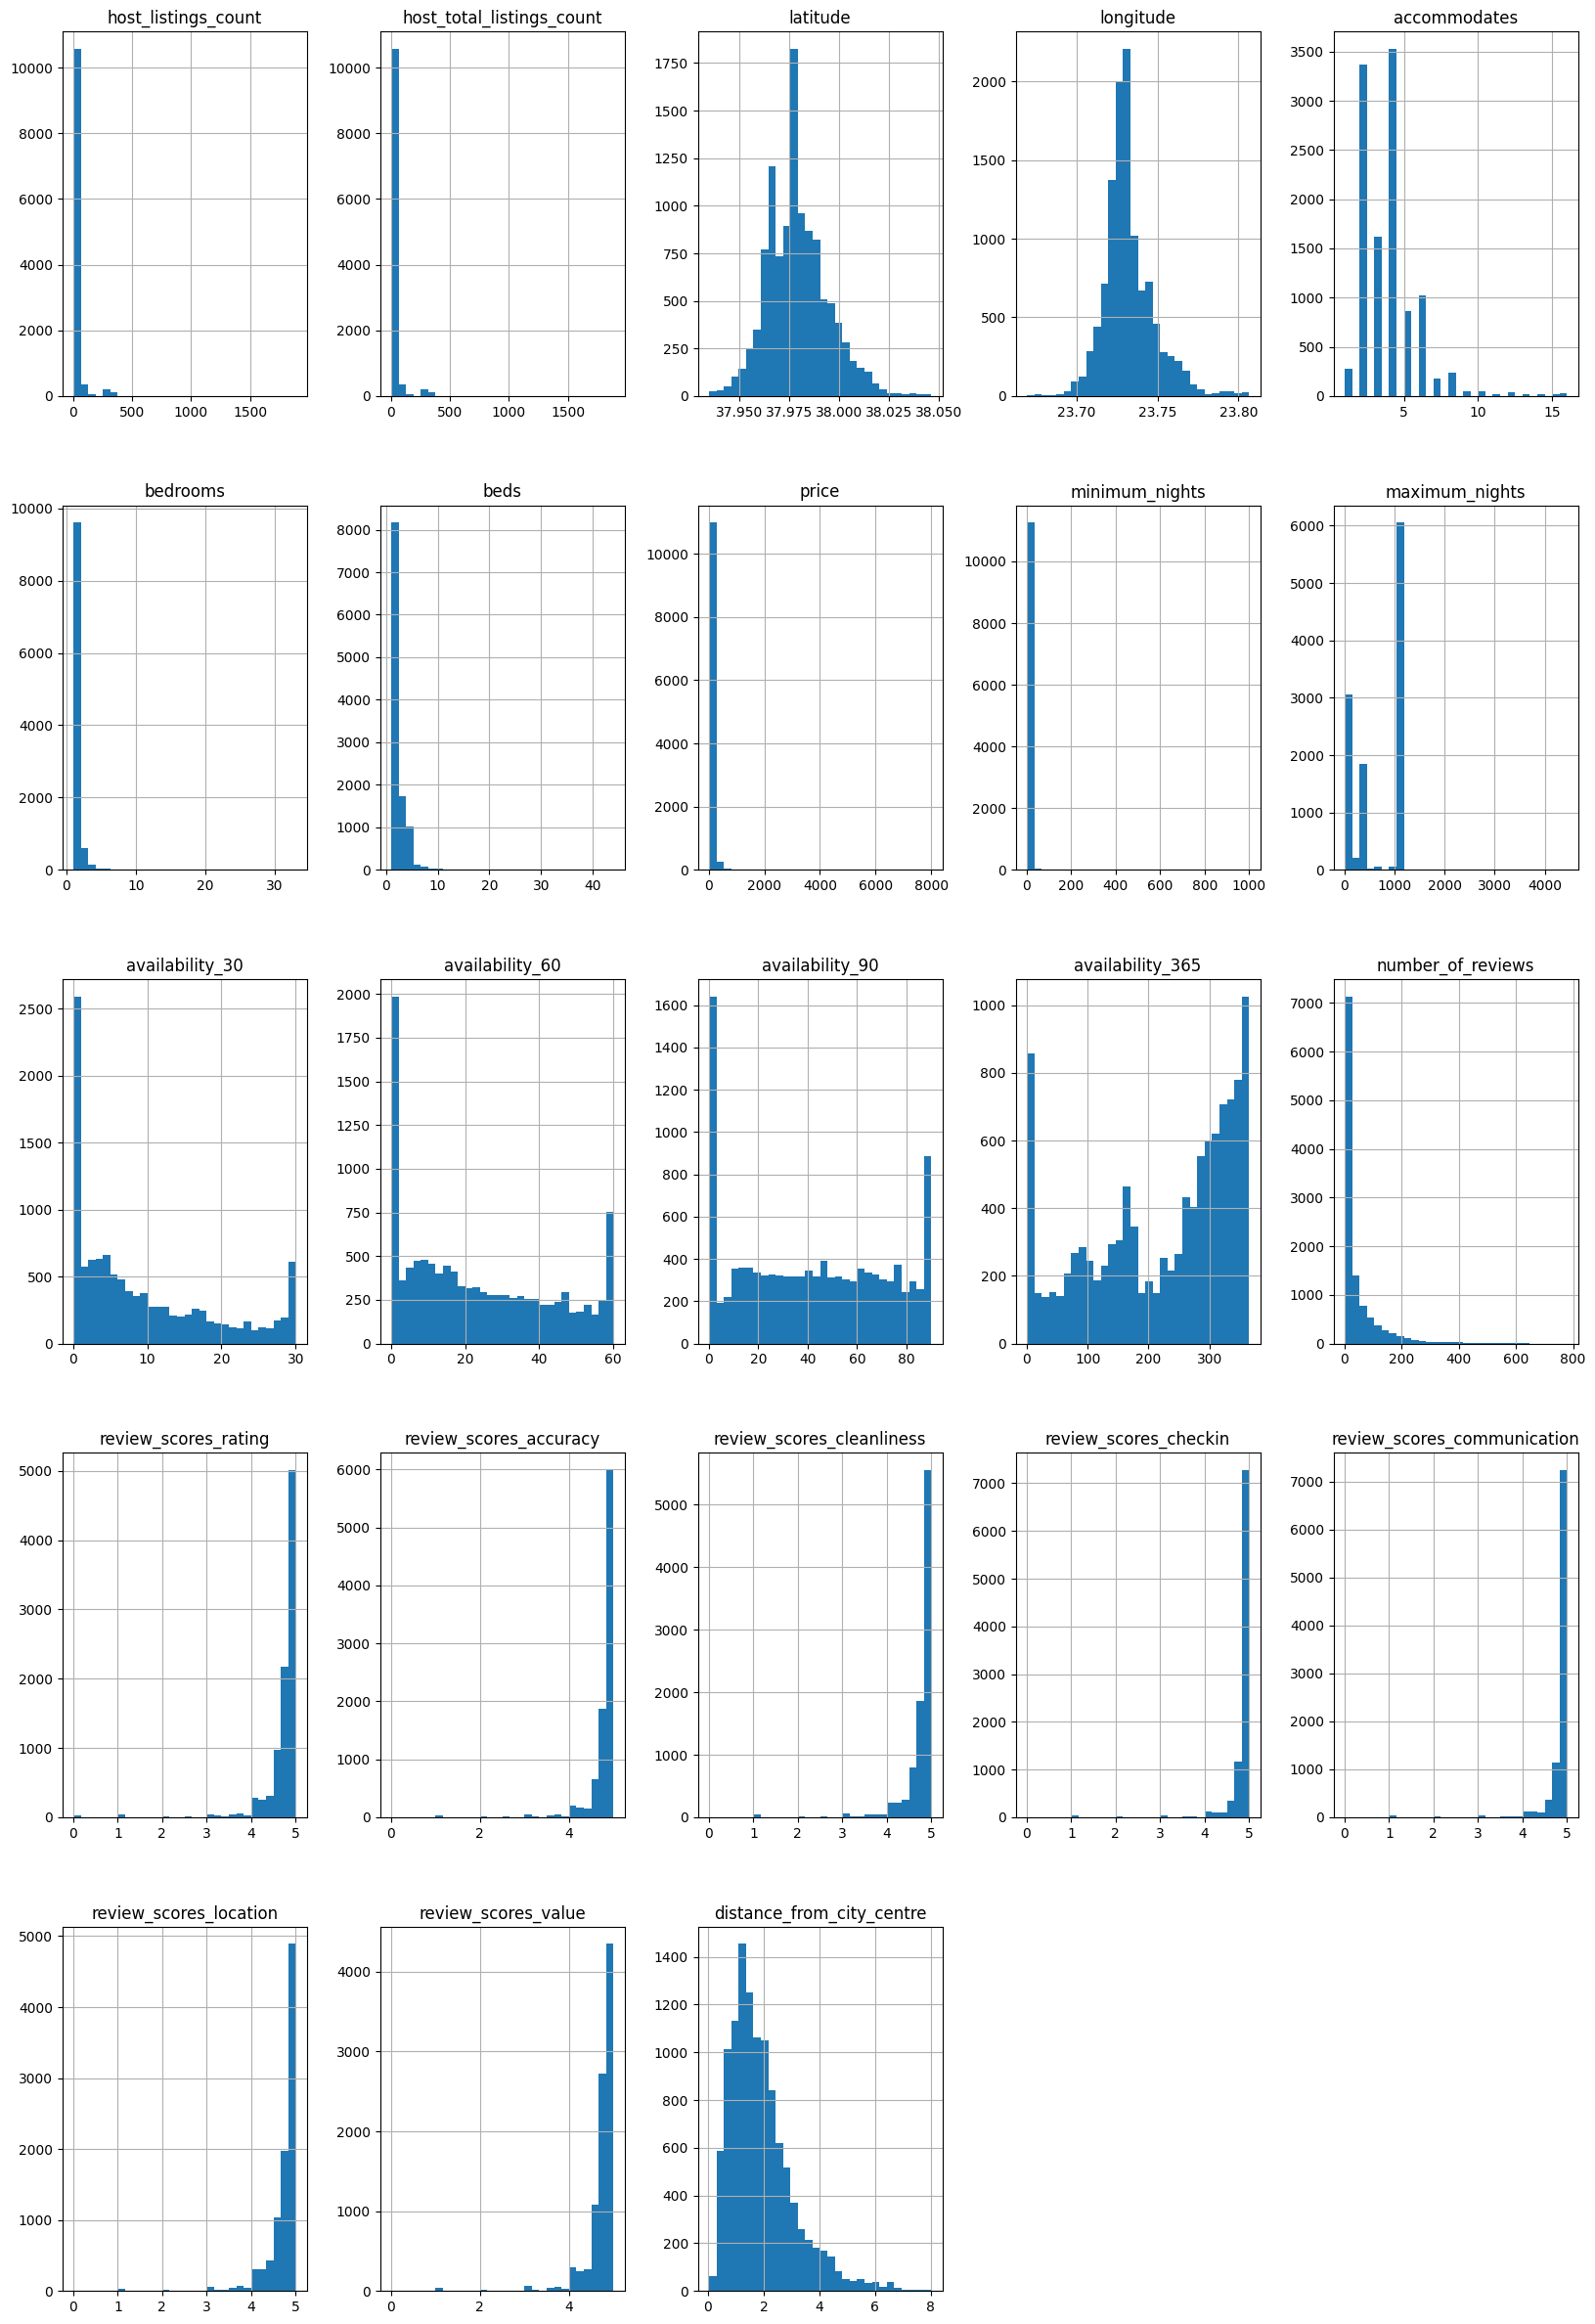

In [6]:
listings.hist(bins=30, figsize=(20,30))
plt.show()

- We need to replace the NaN

In [7]:
listings.isna().sum()

picture_url                       0
host_since                        7
host_response_time             1352
host_is_superhost                 7
host_listings_count               7
host_total_listings_count         7
host_identity_verified            7
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms_text                    7
bedrooms                        891
beds                            136
amenities                         0
price                             0
minimum_nights                    0
maximum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating           2033
review_scores_accuracy         2066
review_scores_cleanliness   

## Cleaning individual columns

#### Price


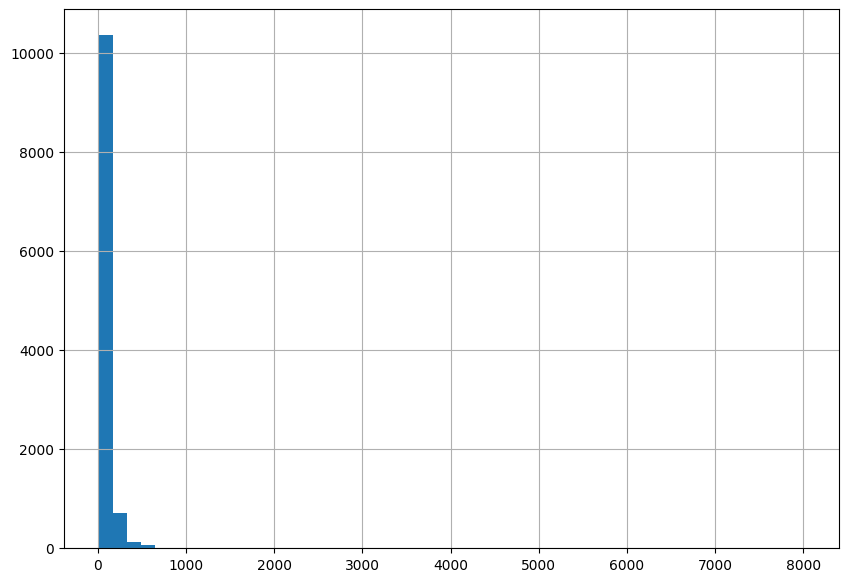

In [8]:
listings.price.hist(bins=50, figsize=(10,7))
plt.show()

#### Drop data based on price
We will keep a logical range 20-500 euros , since the extreme prices seems to be not representative for the area


In [7]:
listings = listings[listings["price"] < 500]
listings = listings[listings["price"] > 20]

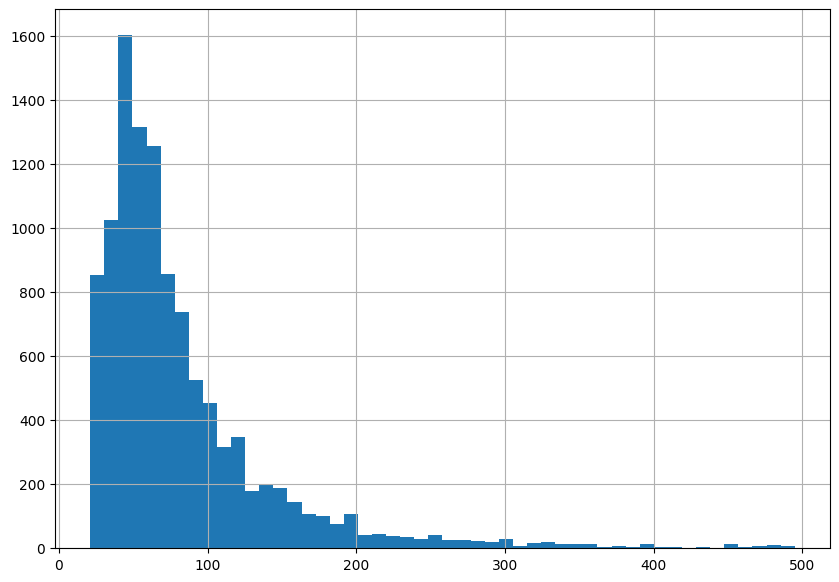

In [11]:
listings.price.hist(bins=50, figsize=(10,7))
plt.show()

In [12]:
print(f" Nightly advertised prices range from euros {min(listings.price)} to euros {max(listings.price)}.")

 Nightly advertised prices range from euros 21 to euros 495.


#### Ηow have prices changed over time

In [13]:
listings["host_since"]=pd.to_datetime(listings['host_since'], errors='coerce')

c:\Users\anasm\Anaconda3\envs\glob2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


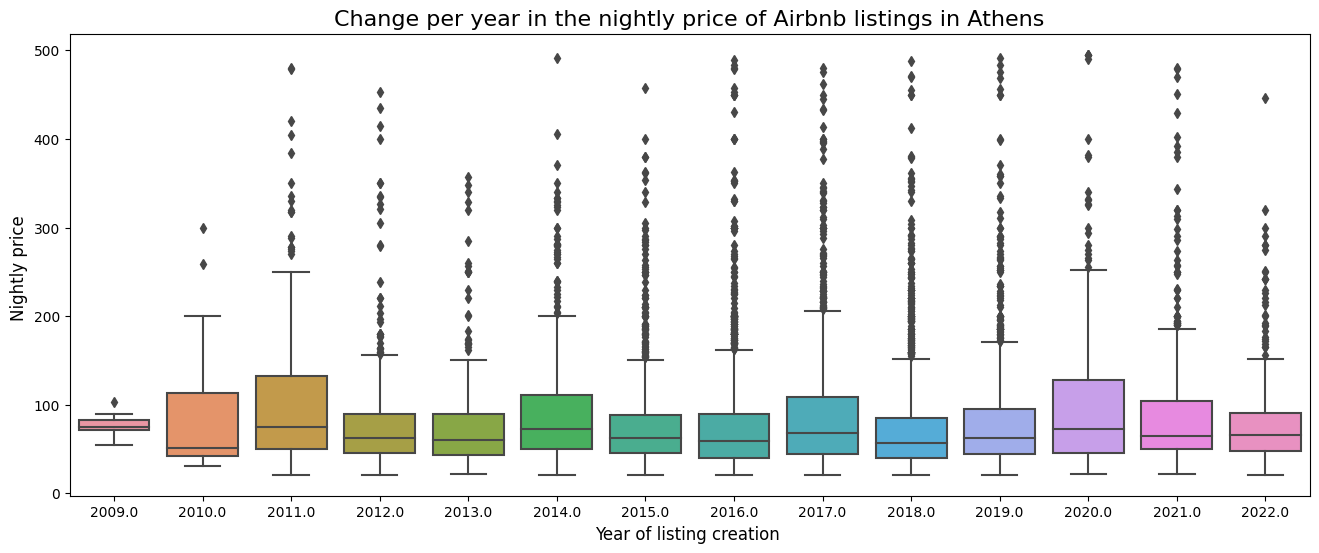

In [14]:
plt.figure(figsize=(16,6))
sns.boxplot(listings.host_since.dt.year, listings.price)
plt.xlabel('Year of listing creation ', fontsize=12)
plt.ylabel('Nightly price ', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Athens', fontsize=16)
plt.show()

the average price per night for Airbnb listings in Athens seems to be higher in years 2011, 2014 & 2020.


#### Average number of people accommodated and bedrooms how do prices differ?



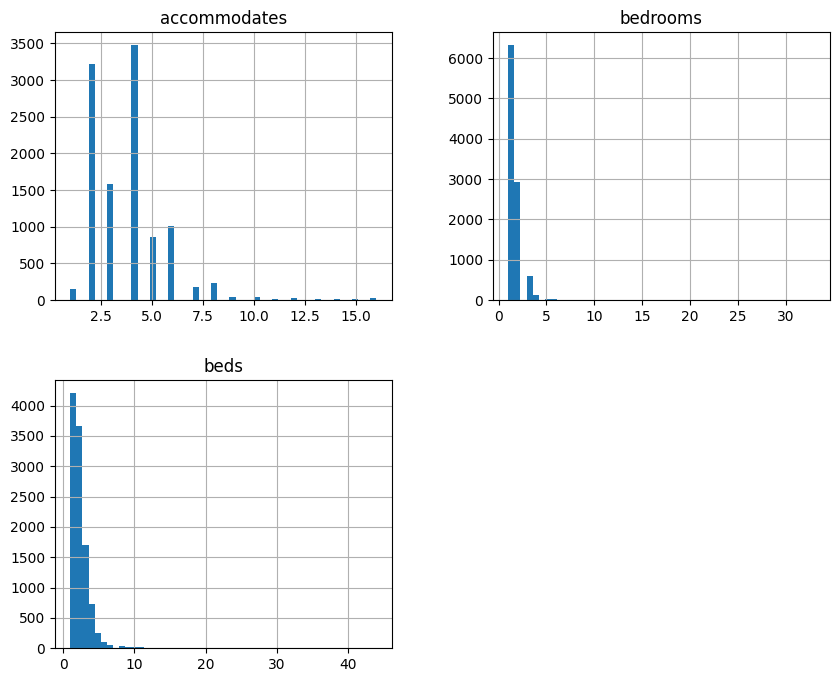

In [15]:
listings[['accommodates',  'bedrooms', 'beds']].hist( bins=50, figsize=(10,8));

The most common property setup sleeps until 4 people with 2 or 3 bedrooms

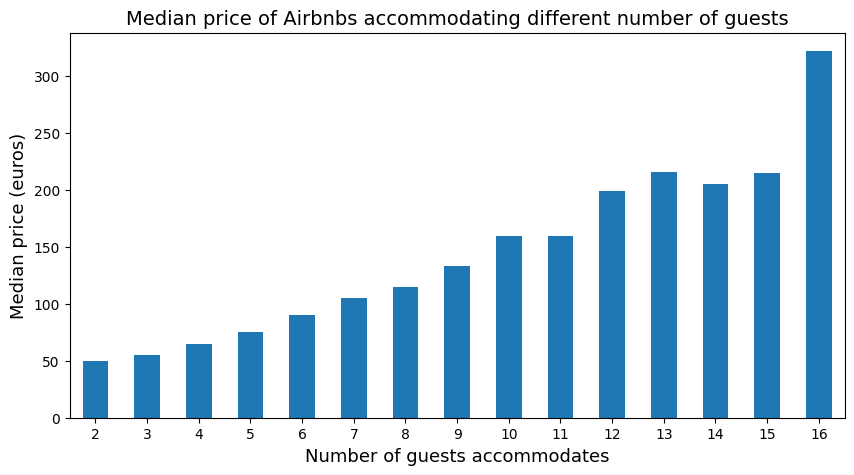

In [16]:
plt.figure(figsize=(10,5))
listings.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodates', fontsize=13)
plt.ylabel('Median price (euros)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

As expected, the more people a property sleeps, the higher the price.

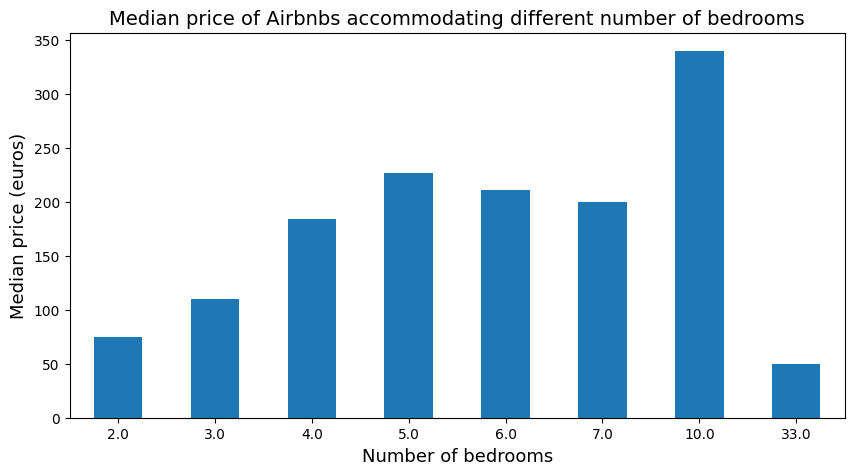

In [17]:
plt.figure(figsize=(10,5))
listings.groupby('bedrooms').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of bedrooms', fontsize=14)
plt.xlabel('Number of bedrooms', fontsize=13)
plt.ylabel('Median price (euros)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

The number of bedrooms has a significant effect on the price, it is noteworthy that a listing with 33 bedrooms has the lowest price.This makes sense , most likely this listing is a big old hotel or a hostel..


## Hosts|

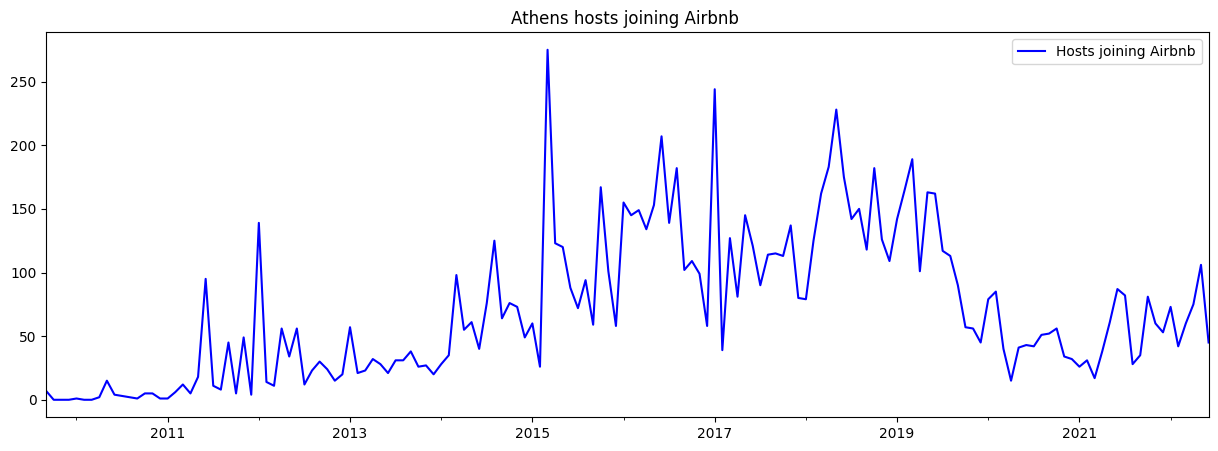

In [20]:
plt.figure(figsize=(15,5))
listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='blue')

plt.title('Athens hosts joining Airbnb ')
plt.legend()
plt.xlim('08 September 2009', '11 June 2022') 
plt.xlabel('')
plt.ylabel('')
plt.show()

We can see that there is a big peak in the number of hosts joining Airbnb in 2015. The airbnb had become famous in Greece as well , encouraging more and more people to take advantage of their homes with a short-term rental


## Reviews

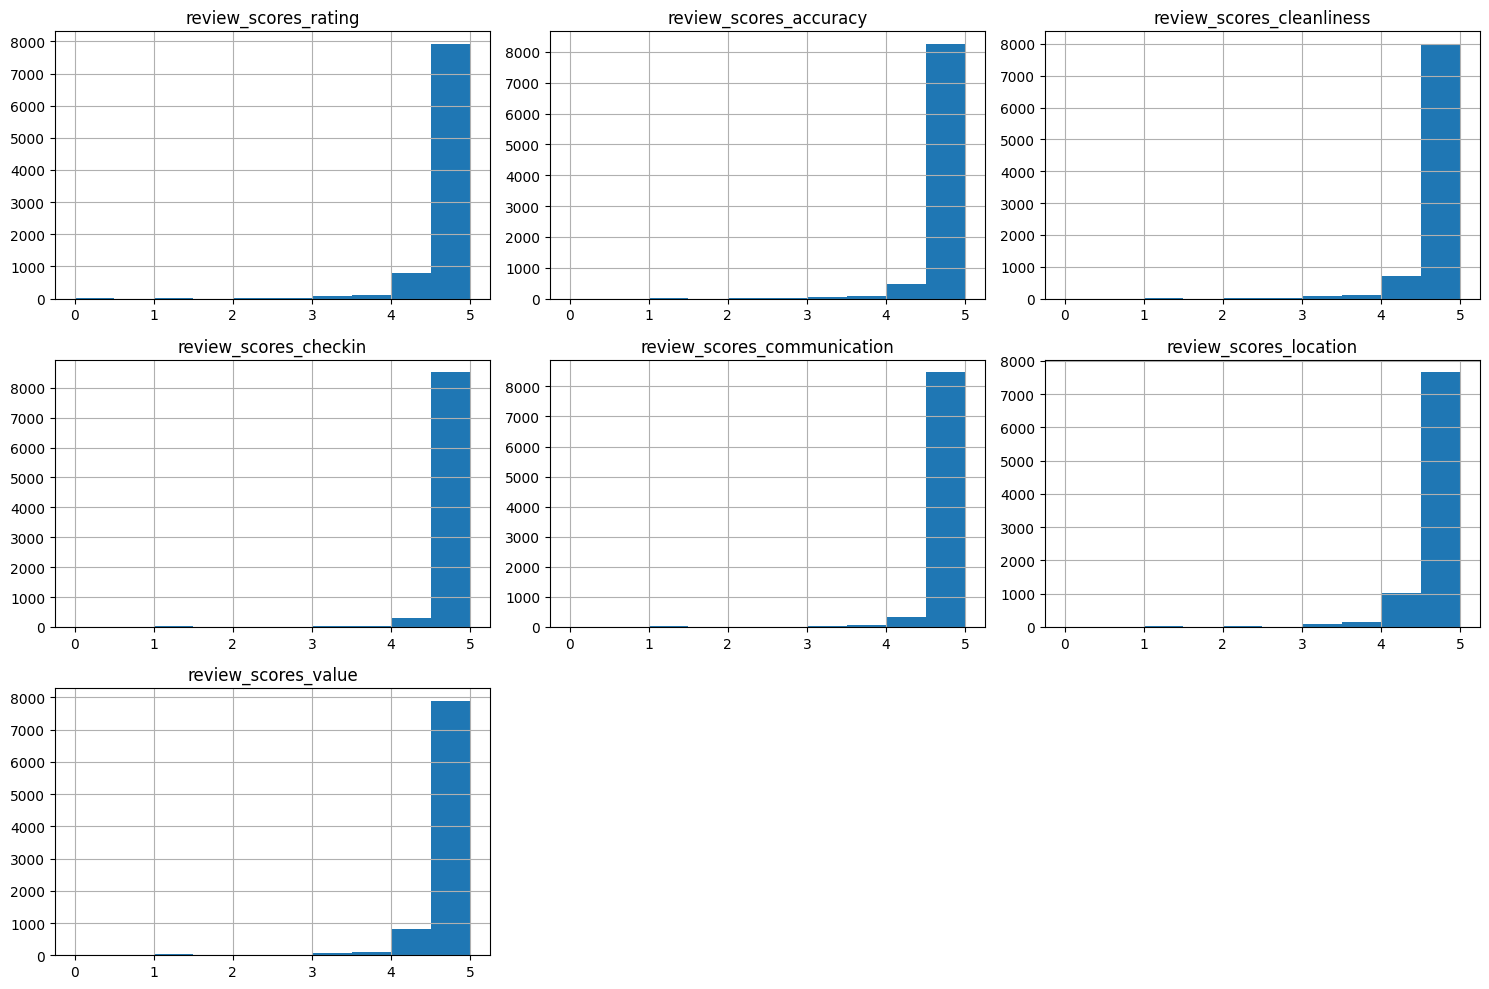

In [21]:
variables_to_plot = list(listings.columns[listings.columns.str.startswith("review_scores") == True])
fig = plt.figure( figsize=(15,10))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    listings[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

## Location


- the color represents the price
- the size of the circle represents the number of reviews

In [22]:
sample_of_listings=listings.sample(frac=0.3, replace=True, random_state=1)

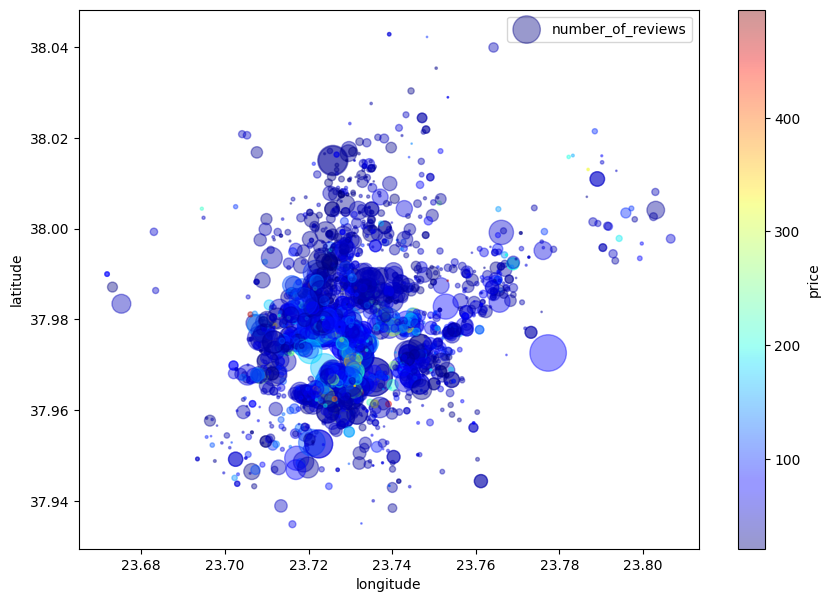

In [23]:
sample_of_listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=sample_of_listings["number_of_reviews"], label="number_of_reviews", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Remarks: Coordinates are not need for further analysis or modeling.

In [8]:
listings.drop(["longitude", "latitude"], axis=1, inplace=True)

### Drop data based on property type

In [25]:
listings.property_type.value_counts()

Entire rental unit                    7066
Entire condo                          1944
Private room in rental unit            327
Entire home                            302
Entire serviced apartment              215
Entire loft                            171
Room in hotel                          167
Room in aparthotel                     152
Room in boutique hotel                 104
Private room in condo                   77
Room in serviced apartment              47
Private room in bed and breakfast       42
Private room in serviced apartment      36
Entire townhouse                        27
Private room in home                    26
Entire guest suite                      23
Private room in guest suite             22
Entire vacation home                    20
Private room in hostel                  20
Shared room in hostel                   17
Entire villa                            12
Private room in townhouse               11
Shared room in rental unit              11
Tiny home  

Replacing any type of Private room, Shared room and Entire home to their main categories.

In [9]:
listings.loc[listings['property_type'].str.contains('Private room'), 'property_type'] = "Private room"
listings.loc[listings['property_type'].str.contains('Shared room'), 'property_type'] = "Shared room"
listings.loc[listings['property_type'].str.contains('Entire home'), 'property_type'] = "Entire home"  

In [27]:
listings.property_type.value_counts()

Entire rental unit            7066
Entire condo                  1944
Private room                   577
Entire home                    303
Entire serviced apartment      215
Entire loft                    171
Room in hotel                  167
Room in aparthotel             152
Room in boutique hotel         104
Room in serviced apartment      47
Shared room                     31
Entire townhouse                27
Entire guest suite              23
Entire vacation home            20
Entire villa                    12
Entire guesthouse               10
Tiny home                       10
Entire place                     8
Room in bed and breakfast        7
Earthen home                     5
Entire cottage                   2
Camper/RV                        2
Floor                            2
Boat                             2
Casa particular                  2
Entire bed and breakfast         1
Cycladic home                    1
Name: property_type, dtype: int64

### Amenities

Here we will see what amenities are useful to model the price of the listings.

In [10]:
# Example of amenities listed
listings.amenities[:1].values
 #Creating a set of all possible amenities
amenities_list = list(listings.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
pd.DataFrame(amenities_set)

,0
0,Whirpool oven
1,2-5 years old
2,Essentials] [\u0397\u03bb\u03b5\u03ba\u03c4\u0...
3,KORRES conditioner
4,TV] [Paid parking off premises
...,...
1809,Pets allowed
1810,GENERAL ELECTRIC refrigerator
1811,Private entrance] [Wifi \u2013 10 Mbps
1812,Private gym in building


Create a dataframe(sparse) with the useful amenities.

In [12]:
amenities_df = pd.DataFrame({'amenities': listings["amenities"].copy()})
amenities_df.loc[amenities_df['amenities'].str.contains('Breakfast'), 'Breakfast'] = "yes"
amenities_df.loc[amenities_df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Breakfast'), 'breakfast'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('TV'), 'tv'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 'yes'

amenities_df.loc[amenities_df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Elevator'), 'elevator'] = 'yes'

amenities_df.loc[amenities_df['amenities'].str.contains('parking', case=False), 'parking'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 'yes'

amenities_df.loc[amenities_df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 'yes'

amenities_df.loc[amenities_df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Essentials'), 'essentials'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Kitchenette'), 'kitchenette'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('pool', case=False), 'pool'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('Self check-in', case=False), 'self_check_in'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('stove', case=False), 'stove'] = 'yes'
amenities_df.loc[amenities_df['amenities'].str.contains('heating', case=False), 'heating'] = 'yes'

amenities_df.drop("amenities", axis=1, inplace=True)

amenities_df.fillna("no", inplace=True)

C:\Users\anasm\AppData\Local\Temp\ipykernel_20416\1420464419.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  amenities_df.loc[amenities_df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 'yes'


In [30]:
amenities_df

,Breakfast,check_in_24h,air_conditioning,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,white_goods,...,outdoor_space,hot_tub_sauna_or_pool,internet,pets_allowed,essentials,kitchenette,pool,self_check_in,stove,heating
id,,,,,,,,,,,,,,,,,,,,,
10595,no,no,yes,yes,no,yes,no,yes,yes,yes,...,no,no,yes,no,yes,no,no,no,yes,yes
10990,no,no,yes,yes,no,yes,no,yes,yes,yes,...,no,no,no,no,yes,no,no,no,yes,yes
10993,no,no,yes,yes,no,yes,no,yes,yes,no,...,no,no,yes,no,yes,no,no,no,yes,yes
2219385,no,no,yes,yes,no,yes,no,yes,yes,yes,...,no,no,yes,no,no,no,no,no,yes,yes
10995,no,no,yes,no,no,yes,no,yes,yes,yes,...,no,no,yes,no,yes,no,no,no,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646258081308550485,no,no,yes,no,no,yes,no,yes,yes,yes,...,yes,no,yes,no,yes,no,no,no,no,yes
48973284,no,no,no,no,no,yes,no,yes,no,no,...,yes,no,no,no,yes,no,no,no,yes,yes
24539337,no,no,yes,yes,no,yes,no,yes,yes,yes,...,no,no,yes,no,yes,no,no,no,yes,no


Merge the computed amenities data with the main dataset.

In [13]:
listings.drop("amenities", axis=1, inplace=True)
listings = pd.merge(listings, amenities_df, on="id")

In [33]:
def binary_count_and_price_plot(col, figsize=(6,4)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=10, y=1)
    plt.subplots_adjust(top=0.90) 
    listings.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    listings.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price euros')
    ax2.set_xlabel('')
    
    plt.show()

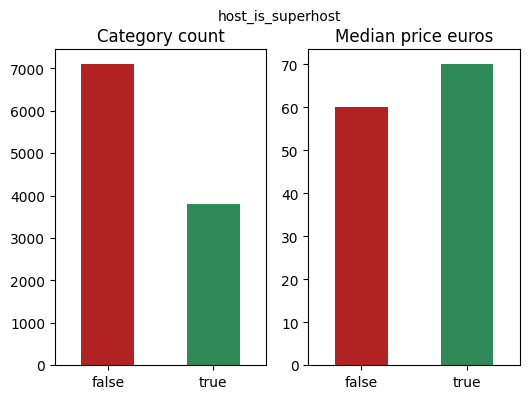

f    0.650679
t    0.349321
Name: host_is_superhost, dtype: float64


In [34]:
binary_count_and_price_plot('host_is_superhost')
print(listings.host_is_superhost.value_counts(normalize=True))

about 35% of hosts are superhosts. However, it seems to improve the median price per night of their Airbnb listings.

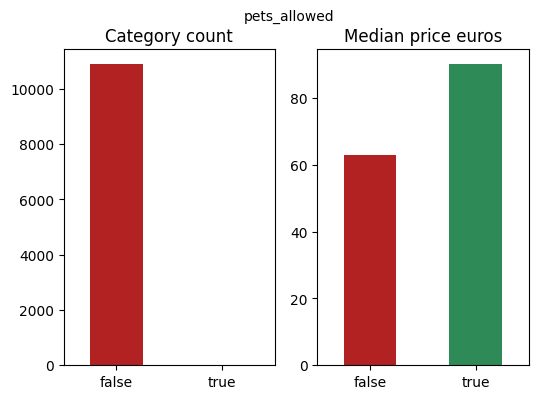

no     0.997525
yes    0.002475
Name: pets_allowed, dtype: float64


In [35]:
binary_count_and_price_plot('pets_allowed')
print(listings.pets_allowed.value_counts(normalize=True))

Only 2% of hosts allow pets..but this seems to significantly affect the price

#### General Anemities

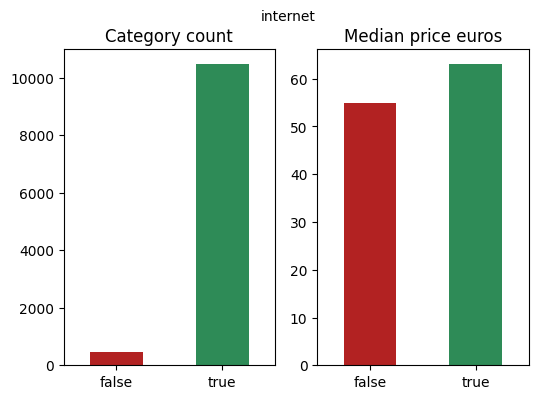

no     0.78068
yes    0.21932
Name: balcony, dtype: float64


In [36]:
binary_count_and_price_plot('internet')
print(listings.balcony.value_counts(normalize=True))

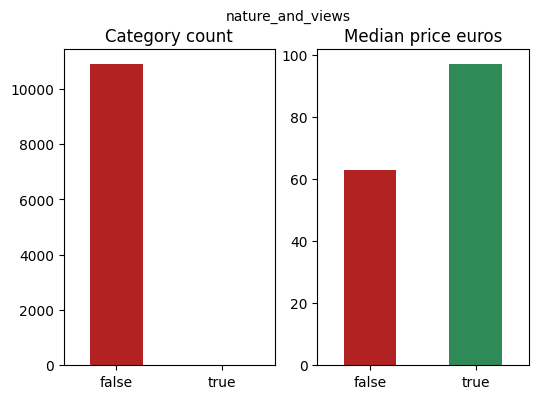

no     0.998075
yes    0.001925
Name: nature_and_views, dtype: float64


In [37]:
binary_count_and_price_plot('nature_and_views')
print(listings.nature_and_views.value_counts(normalize=True))

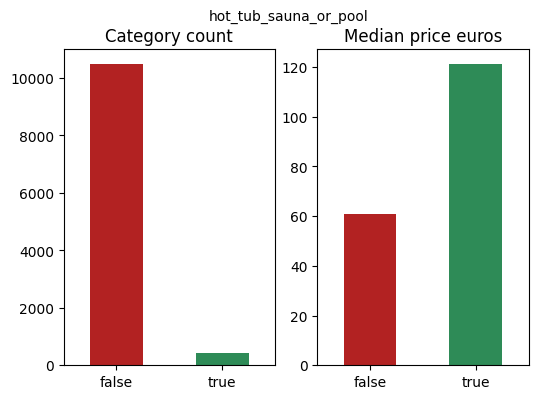

no     0.959949
yes    0.040051
Name: hot_tub_sauna_or_pool, dtype: float64


In [38]:
binary_count_and_price_plot('hot_tub_sauna_or_pool')
print(listings.hot_tub_sauna_or_pool.value_counts(normalize=True))

In [14]:
Y = listings["price"]
pictures = listings["picture_url"]
X = listings.drop(["price", "picture_url", "host_since"], axis=1)

In [44]:
X.columns

Index(['host_response_time', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'distance_from_city_centre', 'Breakfast', 'check_in_24h',
       'air_conditioning', 'balcony', 'nature_and_views', 'bed_linen',
       'breakfast', 'tv', 'coffee_machine', 'white_goods', 'elevator',
       'parking', 'outdoor_space', 'hot_tub_sauna_or_pool', 'internet',
       'pets_allowed', 'essentials', 'kitchenette', 'pool', 'self_check

In [15]:
def set_feature_map():
  """Get a tuple of arrays. The two represent the names of numeric and categorical columns respectively."""
  numeric_cols = []
  categorical_cols = []

  for column in X.columns:
      if is_numeric_dtype(X[column]):
          numeric_cols.append(column)
      else:
          categorical_cols.append(column)
  return (numeric_cols, categorical_cols)

In [16]:
numeric_cols, categorical_cols = set_feature_map()

In [17]:
def get_cols_with_nans():
  """Get the column names for which NANs exist."""
  cols_with_nans = []
  for col in X.columns:
      if not X[col].isnull().any() == False:
          cols_with_nans.append((col, X[col].isnull().sum()))
  return cols_with_nans

In [18]:
get_cols_with_nans()

[('host_response_time', 1294),
 ('host_is_superhost', 7),
 ('host_listings_count', 7),
 ('host_total_listings_count', 7),
 ('host_identity_verified', 7),
 ('bathrooms_text', 5),
 ('bedrooms', 869),
 ('beds', 108),
 ('review_scores_rating', 1927),
 ('review_scores_accuracy', 1957),
 ('review_scores_cleanliness', 1957),
 ('review_scores_checkin', 1957),
 ('review_scores_communication', 1957),
 ('review_scores_location', 1957),
 ('review_scores_value', 1958)]

Replace reviews' NAN values with 0. We do not want to affect our modeling.

In [19]:
review_cols = list(filter(lambda c: "review_scores" in c, numeric_cols)) 
X[review_cols] = X[review_cols].fillna(0, axis=1)

In [20]:
get_cols_with_nans()

[('host_response_time', 1294),
 ('host_is_superhost', 7),
 ('host_listings_count', 7),
 ('host_total_listings_count', 7),
 ('host_identity_verified', 7),
 ('bathrooms_text', 5),
 ('bedrooms', 869),
 ('beds', 108)]

### Correlation plot for the numerical variables

In [57]:
listings[numeric_cols].corr().style.background_gradient()

,host_listings_count,host_total_listings_count,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,distance_from_city_centre
host_listings_count,1.000000,1.000000,0.070507,0.063540,0.028009,-0.024373,0.049097,0.009090,0.012648,0.022869,0.012441,-0.029752,-0.127677,-0.145478,-0.128640,-0.215628,-0.179467,-0.074438,-0.134988,-0.072682
host_total_listings_count,1.000000,1.000000,0.070507,0.063540,0.028009,-0.024373,0.049097,0.009090,0.012648,0.022869,0.012441,-0.029752,-0.127677,-0.145478,-0.128640,-0.215628,-0.179467,-0.074438,-0.134988,-0.072682
accommodates,0.070507,0.070507,1.000000,0.709118,0.763892,-0.007821,0.046078,-0.061368,-0.085980,-0.067327,0.008722,0.012192,0.000044,0.017850,-0.014787,0.006226,0.010641,0.000023,0.019937,-0.044323
bedrooms,0.063540,0.063540,0.709118,1.000000,0.695215,0.001875,0.029924,-0.053267,-0.081707,-0.068720,-0.028137,-0.030283,-0.012977,0.006161,-0.010170,-0.004137,-0.009095,-0.016149,0.010094,0.008717
beds,0.028009,0.028009,0.763892,0.695215,1.000000,-0.002907,0.007048,-0.013097,-0.038849,-0.029005,-0.012509,-0.024366,-0.030007,-0.014180,-0.042928,-0.012341,-0.010361,-0.039542,-0.007374,0.002949
minimum_nights,-0.024373,-0.024373,-0.007821,0.001875,-0.002907,1.000000,0.011148,0.035594,0.025301,0.016227,-0.007727,-0.023349,0.000034,-0.003441,-0.006586,0.008452,0.007494,-0.008484,0.001577,0.026517
maximum_nights,0.049097,0.049097,0.046078,0.029924,0.007048,0.011148,1.000000,-0.072962,-0.081812,-0.084218,0.019904,0.007140,-0.021734,-0.014165,-0.018325,-0.002051,-0.008629,-0.014273,-0.037420,-0.048671
availability_30,0.009090,0.009090,-0.061368,-0.053267,-0.013097,0.035594,-0.072962,1.000000,0.924419,0.860508,0.389830,-0.195900,-0.176702,-0.175367,-0.142744,-0.146610,-0.145667,-0.144996,-0.181378,0.136157
availability_60,0.012648,0.012648,-0.085980,-0.081707,-0.038849,0.025301,-0.081812,0.924419,1.000000,0.968335,0.460639,-0.198513,-0.157064,-0.164449,-0.137973,-0.132206,-0.127302,-0.130916,-0.174511,0.135559
availability_90,0.022869,0.022869,-0.067327,-0.068720,-0.029005,0.016227,-0.084218,0.860508,0.968335,1.000000,0.513860,-0.196535,-0.142209,-0.154971,-0.131596,-0.124697,-0.118674,-0.120553,-0.165655,0.121849


The number of bedroom, beds and guests seems to have a high correlation. Expected, since the more beds or bedrooms there are in a house the more people can be accommodated and automatically increase the price.

We will also remove the host_total_listings_count, because it is highly correlated with the host_listings_count. They both represent the same information.

In [21]:
X.drop(['host_total_listings_count'], axis= 1, inplace=True)

Reset the column names maps.

In [22]:
numeric_cols, categorical_cols = set_feature_map()

In [23]:
categorical_cols

['host_response_time',
 'host_is_superhost',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'license',
 'instant_bookable',
 'Breakfast',
 'check_in_24h',
 'air_conditioning',
 'balcony',
 'nature_and_views',
 'bed_linen',
 'breakfast',
 'tv',
 'coffee_machine',
 'white_goods',
 'elevator',
 'parking',
 'outdoor_space',
 'hot_tub_sauna_or_pool',
 'internet',
 'pets_allowed',
 'essentials',
 'kitchenette',
 'pool',
 'self_check_in',
 'stove',
 'heating']

In [24]:
numeric_cols

['host_listings_count',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'distance_from_city_centre']

Impute and Encode categorical columns

In [25]:
X[categorical_cols] = SimpleImputer(strategy="most_frequent").fit_transform(X[categorical_cols])

!pip install -U scikit-learn

In [26]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('minmax_scaler', MinMaxScaler(feature_range = (0, 1)))
    ])

In [27]:
cat_pipeline = OneHotEncoder()

Create a sparse DataFrame for the categorical variables.

In [28]:
categorical_sparse = cat_pipeline.fit_transform(X[categorical_cols])
categorical_sparse_frame = pd.DataFrame.sparse.from_spmatrix(categorical_sparse, index=X.index)

Split the dataset into three. Here we get the train/validation/test test.

Steps:

- Split the dataset only with the numerical variables,
- Transform the datasets based on the pipelines, and
- Restore the categorical variables into the X sets.

In [29]:
#Split X, Y and train/test
# split the data into train and test set
# Split the data into training and test set
X_train_o, X_test, y_train_o, y_test = train_test_split(X[numeric_cols], Y, test_size=0.2, random_state=24)

# Split the data into training and Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_o, y_train_o, test_size=0.15, random_state=24)

print(len(X_train))
print(len(X_test))

7418
2183


In [30]:
X_train = pd.DataFrame(num_pipeline.fit_transform(X_train), index=X_train.index)

X_val = pd.DataFrame(num_pipeline.transform(X_val), index=X_val.index)
X_test = pd.DataFrame(num_pipeline.transform(X_test), index=X_test.index)

In [31]:
X_train = pd.merge(X_train, categorical_sparse_frame, on="id")
X_val = pd.merge(X_val, categorical_sparse_frame, on="id")
X_test = pd.merge(X_test, categorical_sparse_frame, on="id")

## Sequential NN Models

We built three different models in order to predict the price variable.

All of these models have the same number of layers, but different hyperparameters. We distinguish those that use a different optimizer:

1. Optimizer = Adam, loss function = Mean Absolute Error, epochs = 50, batch_size = 64
2. Optimizer = SGD, loss function = Mean Absolute Error, epochs = 250, batch_size = 64
3. Optimizer = Ftrl, loss function = Mean Absolute Error, epochs = 250, batch_size = 64

#### 1. Optimizer = Adam, loss function = Mean Absolute Error, epochs = 50, batch_size = 64

In [124]:
models = Sequential([
                    Dense(312, input_shape=(X_train.values.shape[1],), activation='selu'),
                    Dropout(.35),
                    Dense(156, activation='selu'),
                    Dropout(.05),
                    Dense(1, activation='linear')
                    ])
optimizer = Adam()
models.compile(optimizer=optimizer,loss="mean_absolute_error")

In [33]:
from keras.utils.vis_utils import plot_model

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 312)               55536     
                                                                 
 dropout_24 (Dropout)        (None, 312)               0         
                                                                 
 dense_37 (Dense)            (None, 156)               48828     
                                                                 
 dropout_25 (Dropout)        (None, 156)               0         
                                                                 
 dense_38 (Dense)            (None, 1)                 157       
                                                                 
Total params: 104,521
Trainable params: 104,521
Non-trainable params: 0
_________________________________________________________________
None


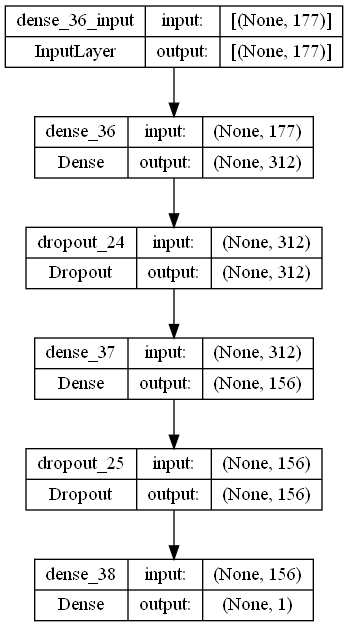

In [100]:
print(models.summary())

plot_model(models, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Adding callback to save the weights. This is our best model.

In [117]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [125]:
checkpoint_path = f'C://Users//anasm//machine_learning//cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

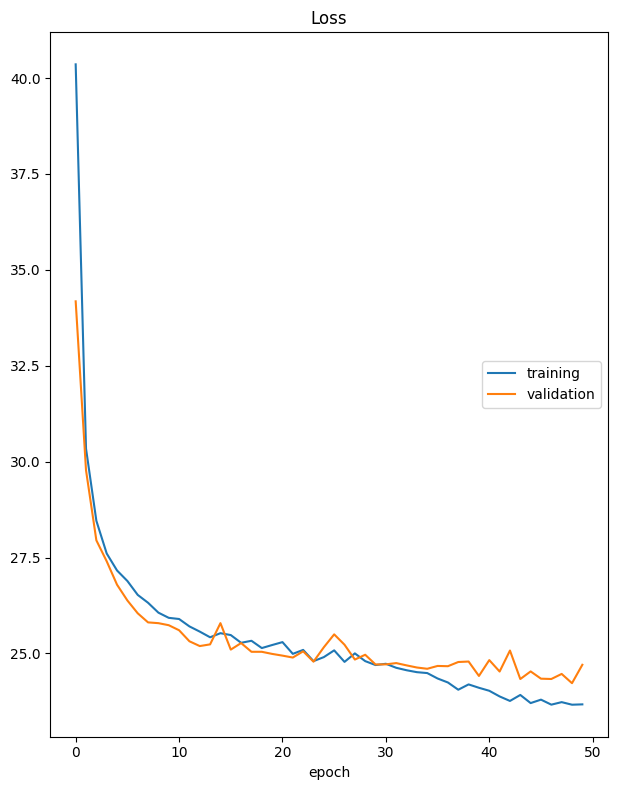

Loss
	training         	 (min:   23.665, max:   40.356, cur:   23.674)
	validation       	 (min:   24.226, max:   34.179, cur:   24.705)


In [126]:
first_nn_history = models.fit(
    X_train.values, 
    y_train.values, 
    epochs=50, 
    validation_data = (X_val.values, y_val.values), 
    batch_size=64,
    verbose=0, 
    callbacks=[PlotLossesKeras(), cp_callback])

In [102]:
print(models.evaluate(X_train.values, y_train.values))
print(models.evaluate(X_val.values, y_val.values))

232/232 [==============================] - 0s 2ms/step - loss: 18.6416
18.641616821289062
41/41 [==============================] - 0s 2ms/step - loss: 24.1455
24.145475387573242


In [103]:
score = models.evaluate(X_test.values, y_test.values)
print(score)

69/69 [==============================] - 0s 2ms/step - loss: 24.1003
24.100269317626953


In [52]:
y_pred = models.predict(X_test)
test_pred_diff = pd.DataFrame(data= {"test": y_test.values, "pred": y_pred.T[0]})
test_pred_diff['pred'] = test_pred_diff['pred'].astype('int')
test_pred_diff

69/69 [==============================] - 0s 2ms/step


,test,pred
0,105,103
1,69,70
2,40,56
3,151,121
4,50,57
...,...,...
2178,61,68
2179,70,62
2180,60,64
2181,45,39


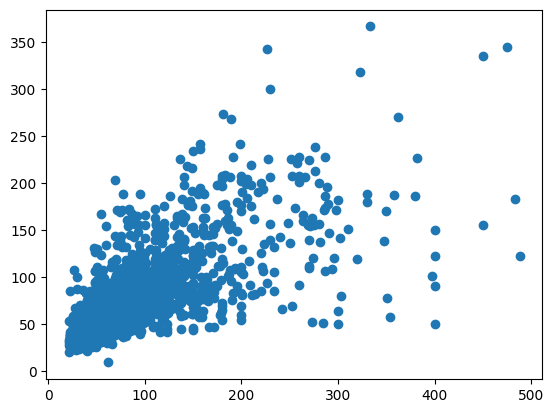

In [53]:
plt.scatter(test_pred_diff['test'], test_pred_diff['pred'])

#### 2. Optimizer = SGD, loss function = Mean Absolute Error, epochs = 250, batch_size = 64

In [65]:
nn2 = Sequential()
nn2.add(Dense(312, input_shape=(X_train.values.shape[1],), activation='selu'))
nn2.add(Dropout(.2))
nn2.add(Dense(156, activation='selu'))
nn2.add(Dropout(.1))
nn2.add(Dense(1, activation='linear'))

# Compiling the model
optimizer2 = SGD(clipnorm=1) # https://stackoverflow.com/a/40824080/7118639 clipping
nn2.compile(optimizer=optimizer2,loss='mean_absolute_error')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 312)               55536     
                                                                 
 dropout_16 (Dropout)        (None, 312)               0         
                                                                 
 dense_25 (Dense)            (None, 156)               48828     
                                                                 
 dropout_17 (Dropout)        (None, 156)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 157       
                                                                 
Total params: 104,521
Trainable params: 104,521
Non-trainable params: 0
_________________________________________________________________
None


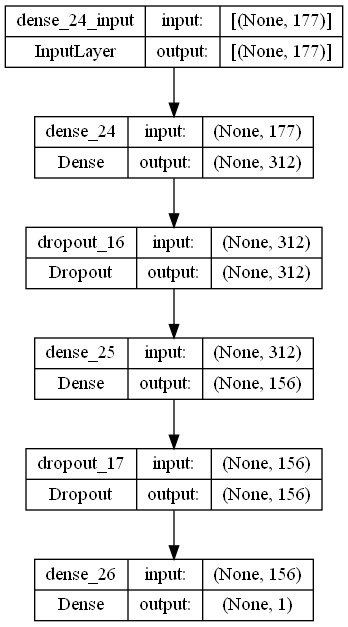

In [67]:
print(nn2.summary())
plot_model(nn2, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

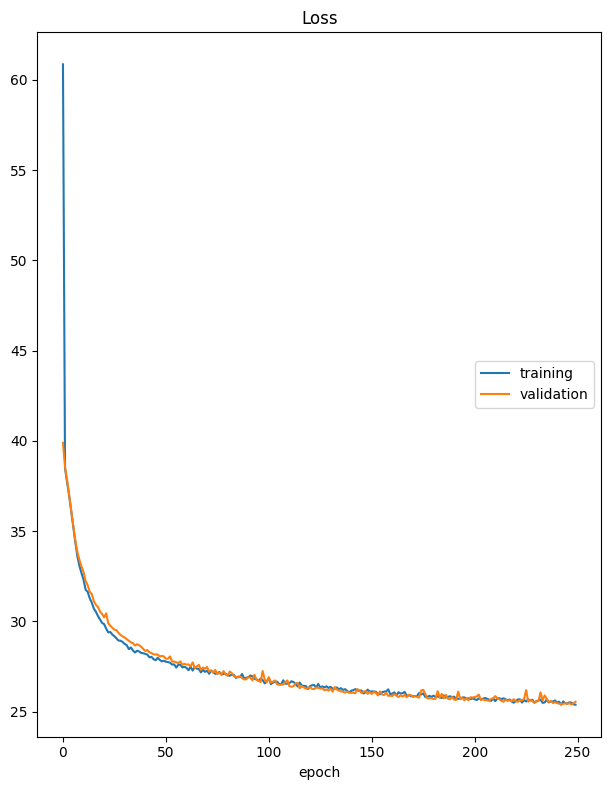

Loss
	training         	 (min:   25.388, max:   60.853, cur:   25.388)
	validation       	 (min:   25.401, max:   39.894, cur:   25.551)


In [66]:
nn2.fit(X_train.values, y_train.values, epochs=250, validation_data = (X_val.values, y_val.values), batch_size=64,verbose=0, callbacks=[PlotLossesKeras()])

In [68]:
print(nn2.evaluate(X_train.values, y_train.values))
print(nn2.evaluate(X_val.values, y_val.values))

232/232 [==============================] - 0s 2ms/step - loss: 24.8420
24.84203338623047
41/41 [==============================] - 0s 2ms/step - loss: 25.5505
25.55054473876953


In [69]:
score = nn2.evaluate(X_test.values, y_test.values)
print(score)

69/69 [==============================] - 0s 2ms/step - loss: 25.3915
25.391496658325195


#### 3. Optimizer = Ftrl, loss function = Mean Absolute Error, epochs = 250, batch_size = 64

In [76]:
nn4 = Sequential()

nn4.add(Dense(312, input_shape=(X_train.values.shape[1],), activation='selu'))
nn4.add(Dropout(.25))
nn4.add(Dense(156, activation='selu'))
nn4.add(Dropout(.05))

nn4.add(Dense(1, activation='linear'))

# Compiling the model
nn4.compile(optimizer=Ftrl(),loss='mean_absolute_error')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 312)               55536     
                                                                 
 dropout_22 (Dropout)        (None, 312)               0         
                                                                 
 dense_34 (Dense)            (None, 156)               48828     
                                                                 
 dropout_23 (Dropout)        (None, 156)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 157       
                                                                 
Total params: 104,521
Trainable params: 104,521
Non-trainable params: 0
_________________________________________________________________
None


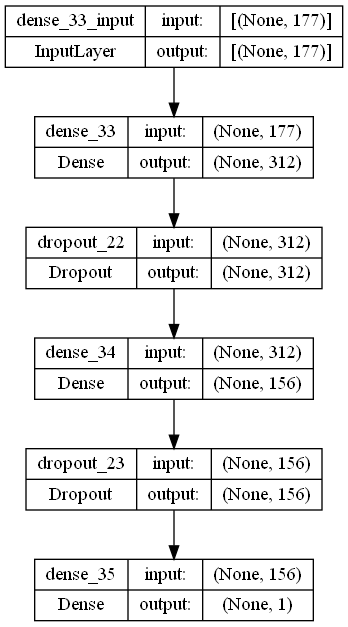

In [94]:
# Model summary
print(nn4.summary())

plot_model(nn4, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

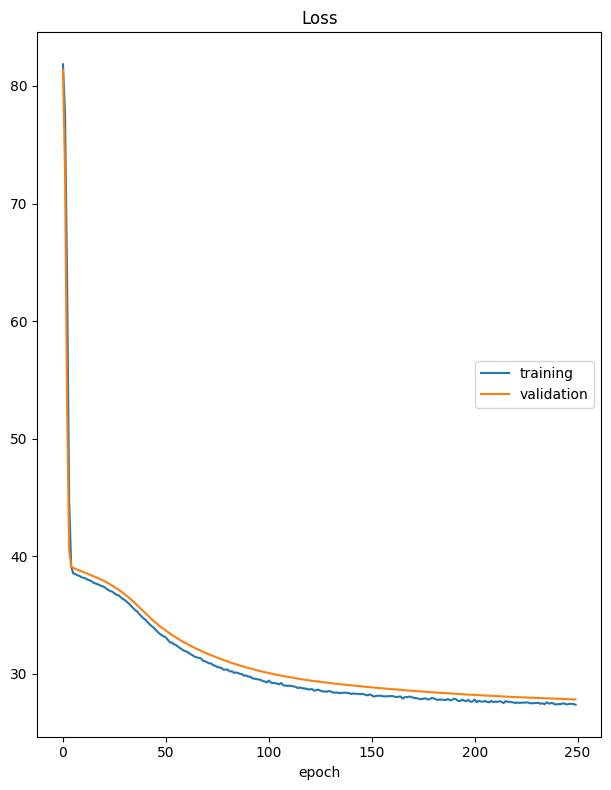

Loss
	training         	 (min:   27.381, max:   81.839, cur:   27.381)
	validation       	 (min:   27.828, max:   81.387, cur:   27.828)


In [77]:
nn4.fit(X_train.values, y_train.values, epochs=250, validation_data = (X_val.values, y_val.values), batch_size=64,verbose=0, callbacks=[PlotLossesKeras()])

In [84]:
print(nn4.evaluate(X_train.values, y_train.values))
print(nn4.evaluate(X_val.values, y_val.values))

232/232 [==============================] - 1s 2ms/step - loss: 27.1030
27.10296058654785
41/41 [==============================] - 0s 2ms/step - loss: 27.8283
27.828332901000977


In [78]:
score = nn4.evaluate(X_test.values, y_test.values)
print(score)

69/69 [==============================] - 0s 2ms/step - loss: 27.1918
27.19183349609375


Restore weights of the best model

In [127]:
models.load_weights(checkpoint_path)

# Random Forest

In [85]:
param_grid = {
    "n_estimators":[200, 300, 500, 600],
    "max_depth":[10, 50, 100, 120],
    "max_features":[12,14, 25, 35, 40, 60]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            scoring = 'neg_mean_absolute_error',  #MSE,
                            n_jobs=-1,
                            verbose=4)

rf_reg_tuned.fit(X_train.values, y_train.values)
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


RandomForestRegressor(max_depth=100, max_features=40, n_estimators=600)

In [93]:
final_rf_reg =RandomForestRegressor(max_depth=100, max_features=40, n_estimators=600)
final_rf_reg.fit(X_train.values, y_train.values)

prediction = final_rf_reg.predict(X_test.values)
mean_absolute_error(y_test.values, prediction)

25.031738364768028